# CM50270 Reinforcement Learning Project

### Lunar Lander V2

## Importing Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
from collections import deque
import gym

import tensorflow.compat.v1 as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Lambda
from tensorflow.keras.optimizers import Adam

from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import HTML, clear_output


/Users/emtiazsamad/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/tensorflow_core/python/framework/dtypes.py:597: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/Users/emtiazsamad/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/tensorflow_core/python/framework/dtypes.py:605: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/Users/emtiazsamad/opt/anaconda3/envs/datascience/

In [2]:
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import random
import math
import glob
import logging
import io
import base64

import keras
import tensorflow as tf2
from keras import backend as K


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import timeit

## Implementing REINFORCE Algorithm with Adaptive Baseline

In [4]:
class RLAgent(object):
    
    def __init__(self, obs_space, action_space, policy_learning_rate, value_learning_rate, 
                 discount, baseline = None, num_layers=3, ma_window_size=50):

        # input/output
        self.num_obs = obs_space  
        self.num_act = action_space.n
        
        # training parameters
        self.plr = policy_learning_rate
        self.vlr = value_learning_rate
        self.gamma = discount
        self.num_layers = num_layers
        self.ma_window_size = ma_window_size
    
        # lists to store the cumulative observations for an episode
        self.eps_observations = []
        self.eps_actions = []
        self.eps_rewards = []

        # set baseline
        if baseline == 'adaptive':
            self.use_adaptive_baseline = True
        else:
            self.use_adaptive_baseline = False

        # build the keras network/s
        self.network()

    def observe(self, state, action, reward):
        """ This function takes the observations the agent received from the environment and stores them
            in the lists above."""

        self.eps_observations.append(state)
        self.eps_actions.append(action)
        self.eps_rewards.append(reward)
        
    def get_action(self, state):
        """ This function feeds the observed state to the network, which returns a distribution
            over possible actions. Sample an action from the distribution and return it."""

        # get actions probabilities
        state = state.reshape([1, self.num_obs])
        
        action_probabilities = self.model(state).numpy().flatten()
        # sample an action
        action = np.random.choice(self.num_act, p=action_probabilities)

        return action

    def train(self):
        """ When this function is called, the accumulated episode observations, actions and discounted rewards
            should be fed into the network and used for training. Use the _get_returns function to first turn 
            the episode rewards into discounted returns. 
            Apply simple or adaptive baselines if needed, depending on parameters."""

        episode_length = len(self.eps_observations)

        # States
        obs_states=np.array(self.eps_observations)

        # Actions (hot encoding)
        mask = np.eye(self.num_act) #unit matric
        actions = mask[self.eps_actions]

        # Discounted Rewards
        discounted_rewards = np.array(self.returns())
                    
        if self.use_adaptive_baseline:
            
            # update model_baseline parameters
            self.model_baseline.train_on_batch(x = obs_states, y = discounted_rewards)
            
            # subtract Baseline
            discounted_rewards -= self.model_baseline(obs_states).numpy().flatten() #advantage
        
        # update model (policy) parameters weights
        self.model.train_on_batch(x = obs_states, y = actions, sample_weight = discounted_rewards)
        
        # reset cumulative lists
        self.eps_observations = []
        self.eps_actions = []
        self.eps_rewards = []

    def returns(self):
        """ This function should process self.episode_rewards and return the discounted episode returns
            at each step in the episode. """ 
               
        discounted_rewards = []
        cum_return = 0

        #a[::-1] reverse the list
        for r in self.eps_rewards[::-1]:  
            cum_return = (cum_return*self.gamma) + r
            discounted_rewards.insert(0, cum_return) #insert as the first value
    
        return discounted_rewards


    def network(self):
        """ This function should build the network that can then be called by decide and train. 
            The network takes observations as inputs and has a policy distribution as output."""

        model = Sequential()
        for i in tf2.range(self.num_layers):
            model.add(Dense(16, activation="relu"))
        model.add(Dense(self.num_act, activation="softmax")) 
        
        model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate=self.plr))
        self.model = model

        if self.use_adaptive_baseline == True:
            model_baseline = Sequential()
            for i in tf2.range(self.num_layers):
                  model_baseline.add(Dense(16, activation="relu"))
            model_baseline.add(Dense(1)) 
        
            model_baseline.compile(loss = "mse", optimizer = Adam(learning_rate=self.vlr))
            self.model_baseline = model_baseline

In [5]:
def run_experiment(experiment_name, env, num_episodes, policy_learning_rate=0.001, value_learning_rate=0.001, baseline=None, 
                   num_layers=3):

    #Initiate the learning agent
    agent = RLAgent(obs_space=env.observation_space.shape[0], action_space=env.action_space, policy_learning_rate=policy_learning_rate, 
                    value_learning_rate=value_learning_rate, discount=0.99, baseline=baseline, num_layers=num_layers)

    rewards = []
    all_eps_frames = []
    step = 0
    
    #loop each episode
    for episode in range(1, num_episodes+1):
    
        #Update results plot and occasionally store an episode movie
        eps_frames = None
#         if episode >= 0:
#             results[experiment_name] = np.array(rewards) #dict
#             results.plot(10)
        if (episode < 10) or (episode>=989 and episode<=999) or (episode>=1989 and episode<=1999):
            eps_frames = []
            
        #initialise, Reset the environment to a new episode
        observation = env.reset()
        episode_reward = 0
        
        #loop each step 
        while True:
            #occasionally store an episode movie
            if eps_frames is not None:
                eps_frames.append(env.render(mode='rgb_array'))

            # 1. Decide on an next action based on the observations
            action = agent.get_action(observation)

            # 2. Take action in the environment
            next_observation, reward, done, info = env.step(action)
            episode_reward += reward

            # 3. Store the information returned from the environment for training the model
            agent.observe(observation, action, reward)

            # 4. When we reach a terminal state ("done"), use the observed episode to train the network
            if done:
                rewards.append(episode_reward)
                if episode % 10 == 0:
                    print("episode: {}/{}, reward: {}".format(episode, num_episodes, episode_reward))
                    
                if eps_frames is not None:
                    all_eps_frames.append(eps_frames)
                agent.train() #each epo done then train the model
                break

            # Reset for next step
            observation = next_observation
            step += 1
    results[experiment_name] = np.array(rewards)
    
    return all_eps_frames, agent

### Gym Setup

Here we load the Reinforcement Learning environments from Gym.

We limit each episode to 500 steps so that we can train faster. 

In [6]:
num_episodes = 2000

In [7]:
lunar_env = gym.make('LunarLander-v2')
lunar_env._max_episode_steps = 1000

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8

### Run the experiment

In [8]:
results = {}

In [9]:
policy_learning_rate = 0.0025
value_learning_rate = 0.005

# REINFORCE + Adaptive Baseline reduce the variance of the updates by subtracting a baseline function
episodes_reinforce, d_model = run_experiment("REINFORCE (adaptive baseline)", lunar_env, num_episodes, policy_learning_rate, 
                                   value_learning_rate, baseline='adaptive')

episode: 10/2000, reward: -333.2707676006594
episode: 20/2000, reward: -74.69445901647435
episode: 30/2000, reward: -298.4659380076241
episode: 40/2000, reward: -112.77082528008467
episode: 50/2000, reward: -444.85784814071724
episode: 60/2000, reward: -39.63073134097711
episode: 70/2000, reward: -217.18732226998608
episode: 80/2000, reward: -93.55513779082985
episode: 90/2000, reward: -260.71724803661857
episode: 100/2000, reward: -289.76756144911496
episode: 110/2000, reward: -151.9885542288423
episode: 120/2000, reward: -140.6519798223521
episode: 130/2000, reward: -194.93361724774297
episode: 140/2000, reward: -79.94204164557311
episode: 150/2000, reward: -105.93814600724069
episode: 160/2000, reward: -95.46524961968504
episode: 170/2000, reward: -161.4017147786722
episode: 180/2000, reward: -87.78430713095274
episode: 190/2000, reward: -190.18853657587005
episode: 200/2000, reward: -217.9616547157661
episode: 210/2000, reward: -124.04053723972567
episode: 220/2000, reward: -62.221

In [10]:
lunar_env.close()

In [11]:
'''RUN CELL AND UNCOMMENT LAST LINE IF MODEL HAS BEEN TRAINED, OTHERWISE IGNORE'''
df_RF = pd.DataFrame()
df_RF['Reward'] = results['REINFORCE (adaptive baseline)']
df_RF.to_csv('REINFORCE Rewards.csv')

In [26]:
def render(episode, env, m_name, n_ep):
    
    fig = plt.figure()
    img = plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    def animate(i):
        img.set_data(episode[i])
        return img,
    
    mp4 = os.getcwd() + '/' + str(m_name) + ' Videos/' + str(m_name) + '_' + str(n_ep) +'.mp4'
    anim = FuncAnimation(fig, animate, frames=len(episode), interval=1, blit=True)
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps = 50, metadata = dict(artist = 'Me'), bitrate = 1800)
    anim.save(mp4, writer = writer, dpi=100)

    html =  HTML(anim.to_html5_video())

    plt.close(fig)
    
    return html

def save_video(episodes_frames, methods, env):
    path = os.getcwd() + '/' + methods + ' Videos'
    if not os.path.exists(path):
        os.makedirs(path)
        
    for i in range(len(episodes_frames)):
        render(episodes_frames[i], env, methods, i)

In [13]:
save_video(episodes_reinforce, 'REINFORCE', lunar_env)

## Implementing DDQN (Double DQN) Algorithm with Experience Replay

In [2]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def network(opt, input_dim, action_size):
    network = Sequential()
    network.add(Dense(128, input_dim = input_dim, activation = "relu"))
    network.add(Dense(128, activation = "relu"))
    network.add(Dense(action_size, activation = "linear"))
    network.compile(optimizer = opt, loss = 'mse')
    return network

class DDQNAgent:
    def __init__(self, env, optimizer, batch_size, gamma=0.99, epsilon=1, decay=0.995):
        self.env = env
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        
        self.exp_replay = deque(maxlen=1000000)
        
        self.qnetwork = network(self.optimizer, self.state_size, self.action_size)
        self.target = network(self.optimizer, self.state_size, self.action_size)
        
        self.rewards = None
        self.average_reward = None
        self.time = []

    def policy(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_size)
        else:
            state = np.reshape(state, [1, self.state_size])
            actions = self.qnetwork.predict(state)
            action = np.argmax(actions[0])
        return action
    
    def add_memory(self, state, action, reward, next_state, terminal):
        self.exp_replay.append((state, action, reward, next_state, terminal))
    
    def update_target(self):
        return self.target.set_weights(self.qnetwork.get_weights())
    
    def train(self):
        batch_size = min(len(self.exp_replay), self.batch_size)
        batch = random.sample(self.exp_replay, batch_size)
        
        states = np.ndarray((batch_size, self.state_size))
        next_states = states.copy()
        
        actions = np.ndarray((batch_size, 1))
        rewards = actions.copy()
        terminals = actions.copy()
        
        step = 0
        for memory in batch:
            states[step], actions[step], rewards[step], next_states[step], terminals[step] = memory
            step += 1
         
        q_next = self.target.predict(next_states) * (np.ones(shape = terminals.shape) - terminals)
        q_next = np.max(q_next, axis=1)
        q = self.qnetwork.predict(states)
        
        for i in range(batch_size):
            q[i,int(actions[i,0])] = rewards[i] + self.gamma * q_next[i]
            
        self.qnetwork.fit(states, q, verbose = 0)
    
    def train_model(self, env, num_episodes):
        
        count = 0
        rewards, average_reward = [], []
        
        
        average = deque(maxlen=100)
        
        txt = open('Saved Networks.txt', 'w')
        path = os.getcwd() + '/Saved Networks'
        if not os.path.exists(path):
            os.makedirs(path)
        
        start = time.time()

        for episode in range(1, num_episodes + 1):
            state = env.reset()
            total = 0
            terminal = False
            
            while not terminal:
                action = self.policy(state)
                next_state, reward, terminal, _ = env.step(action)
                
                total += reward
                
                self.add_memory(state, action, reward, next_state, terminal)
                self.train()
                state = next_state
                
        
            average.append(total)
            average_reward.append(np.mean(average))
            rewards.append(total)

            self.update_target()
            self.epsilon = max(0.1, self.decay * self.epsilon)
            end = time.time()
            self.time.append(end - start)
            
            if episode % 10 == 0:
                print(f'Episode {episode}: {total}')
            
            if (episode % 100 == 0) or episode == 1:
                self.qnetwork.save(('Saved Networks/ddqn_model_{0}'.format(count)))
                txt.write("Save {0} - Episode {1}, Reward: {2}, Average Reward: {3}\n".format(count, 
                                                                                          episode, 
                                                                                          total, 
                                                                                          np.mean(average)))
                count += 1

        self.rewards = rewards
        self.average_reward = average_reward
        
    def test_model(self, env, num_episodes, file):
        self.qnetwork = tf.keras.models.load_model(file)
        self.epsilon = 0
        
        count = 0
        rewards, average_reward, all_eps_frames = [], [], []
        average = deque(maxlen=100)
        eps_frames = None
        
        for episode in range(1, num_episodes + 1):
            state = env.reset()
            total = 0
            eps_frames = []
            terminal = False
            
            while not terminal:
                action = self.policy(state)
                next_state, reward, terminal, _ = env.step(action)
                
                eps_frames.append(env.render(mode='rgb_array'))
                
                total += reward                
                state = next_state
                
                if terminal:
                    all_eps_frames.append(eps_frames)
            
            average.append(total)
            average_reward.append(np.mean(average))
            rewards.append(total)
            print(f'Episode {episode}: {total}')

        self.rewards = rewards
        self.average_reward = average_reward

        return all_eps_frames
        
    def plot_results(self):
        plt.figure(figsize = (10, 6), dpi = 100)

        plt.plot(self.rewards, alpha = 0.7, label = 'Rewards')
        plt.plot(self.average_reward, 'red', label = 'Average Rewards')
        plt.axhline(y = 200, color = 'orange', linestyle = '-', label = 'Threshold')
        
        plt.xlim(0, len(self.rewards))
        plt.title('Learning Curve', fontweight = 'bold')
        plt.xlabel('Episode', fontweight = 'bold')
        plt.ylabel('Reward', fontweight = 'bold')
        plt.legend(loc = 'lower right')

In [6]:
env = gym.make("LunarLander-v2")
optimizer = Adam(learning_rate = 0.0001)
agent = DDQNAgent(env, optimizer, batch_size = 64)

In [7]:
agent.train_model(env, num_episodes = 100)

Episode 10: -358.5576352647416
Episode 20: -131.0986116763333
Episode 30: -134.2854590285679
Episode 40: -332.13661673085346
Episode 50: -63.70417063744568
Episode 60: -187.49992193989513
Episode 70: -92.1852674759457
Episode 80: -161.40888921042458
Episode 90: -121.10632698541141
Episode 100: 8.436215378987754


## Storing Rewards per Episode in DataFrame and Saving as CSV File

In [18]:
'''RUN CELL AND UNCOMMENT LAST LINE IF MODEL HAS BEEN TRAINED, OTHERWISE IGNORE'''
df = pd.DataFrame()
df['Reward'] = agent.rewards
df['Average Reward'] = agent.average_reward
df.to_csv('DDQN Rewards.csv')

## Reloading Instance with Saved Rewards and Plotting Train Results

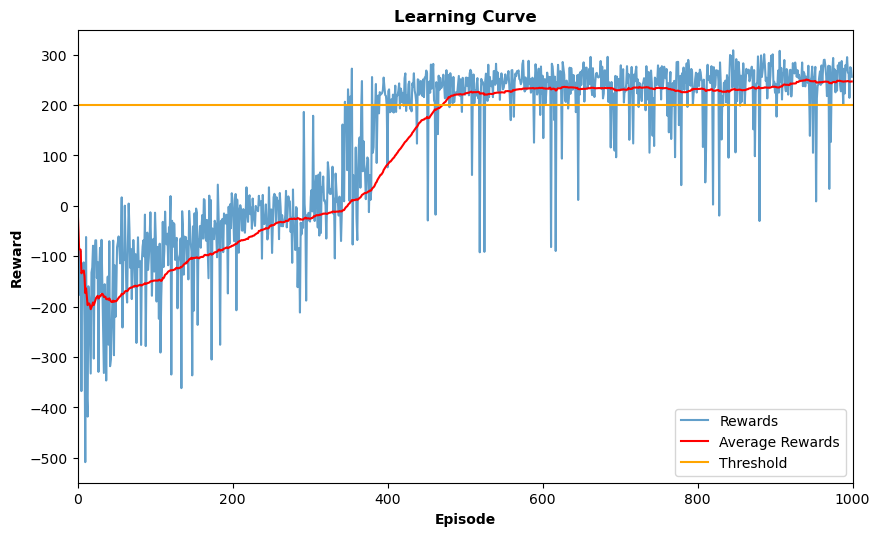

In [5]:
df = pd.read_csv('DDQN Rewards.csv')
env = gym.make("LunarLander-v2")
optimizer = Adam(learning_rate = 0.0001)

agent_plt = DDQNAgent(env, optimizer, batch_size = 64)
agent_plt.rewards = df['Reward']
agent_plt.average_reward = df['Average Reward']
agent_plt.plot_results()

## Testing Models and Recording Performance at Varying Number of Episodes Trained

In [10]:
env = gym.make("LunarLander-v2")
optimizer = Adam(learning_rate = 0.0001)


episodes_ddqn = []

agent_test = DDQNAgent(env, optimizer, batch_size = 64)
print('2000 Episodes Trained')
test = agent_test.test_model(env, 3, 'Saved Networks/ddqn_model_20')

episodes_clip = []
for i in range(3):
    episodes_clip += test[i]
episodes_ddqn.append(episodes_clip)

2000 Episodes Trained
Episode 1: 293.70857334976165
Episode 2: 273.43203487498573
Episode 3: 231.02335347238812


In [ ]:
env.close()

In [ ]:
save_video(episodes_ddqn, 'DDQN', env)

## Implementing PPO(Proximal Policy Optimization) Algorithm with Experience Replay

In [27]:
class PPO_Buffer:
    def __init__(self, batch_size):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.values = []
        self.rewards = []
        self.dones = []  # terminal flags
        self.batch_size = batch_size

    def pick_batch(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i: i+self.batch_size] for i in batch_start]

        return np.array(self.states), np.array(self.actions), np.array(self.logprobs), \
                  np.array(self.values), np.array(self.rewards), np.array(self.dones), batches

    def save_buffer(self, state, action, logprob, value, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.logprobs.append(logprob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_buffer(self):
        self.states.clear()
        self.actions.clear()
        self.logprobs.clear()
        self.values.clear()
        self.rewards.clear()
        self.dones.clear()
         

In [28]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_d, alpha, fc1_d=256, fc2_d=256, fc3_d=128):
        super(ActorNetwork, self).__init__()

        self.actor = nn.Sequential(
            nn.Linear(*input_d, fc1_d),
            nn.ReLU(),
            nn.Linear(fc1_d, fc2_d),
            nn.ReLU(),
            nn.Linear(fc2_d, fc3_d),
            nn.ReLU(),
            nn.Linear(fc3_d, n_actions),
            nn.Softmax(dim=-1),
        )
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

    def forward(self, state):
        return Categorical(self.actor(state))


class CriticNetwork(nn.Module):
    def __init__(self, input_d, alpha, fc1_d=256, fc2_d=256, fc3_d=128):
        super(CriticNetwork, self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(*input_d, fc1_d),
            nn.ReLU(),
            nn.Linear(fc1_d, fc2_d),
            nn.ReLU(),
            nn.Linear(fc2_d, fc3_d),
            nn.ReLU(),
            nn.Linear(fc3_d, 1),
        )
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

    def forward(self, state):
        return self.critic(state)

In [34]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=3e-4, gae=0.95, clip=0.2, batch_size=5, n_epochs=4):
        self.gamma = gamma
        self.clip = clip
        self.n_epochs = n_epochs
        self.gae = gae

        self.buffer = PPO_Buffer(batch_size)
        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)


    def choose_action(self, observation):
        state = torch.tensor(np.array([observation]), dtype=torch.float).to(device)
        # give distribution from neural network for choosing an action
        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        prob = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()

        return action, prob, value

    def learn(self):
        for _ in range(self.n_epochs):
            s, a, old_p, v, r, dones, batches = self.buffer.pick_batch()
            advantage = np.zeros(len(r))

            for t in range(len(r)-1):
                discount = 1
                advantage_t = 0
                for k in range(t, len(r)-1):
                    advantage_t += discount*(r[k] + self.gamma*v[k+1] * (1 - int(dones[k])) - v[k])
                    discount *= self.gamma * self.gae
                advantage[t] = advantage_t
            advantage = torch.tensor(advantage).to(device)
            values = torch.tensor(v).to(device)

            for b in batches:
                states = torch.tensor(s[b], dtype=torch.float).to(device)
                old_probs = torch.tensor(old_p[b]).to(device)
                actions = torch.tensor(a[b]).to(device)

                dist = self.actor(states)
                critic_value = torch.squeeze(self.critic(states))

                new_probs = dist.log_prob(actions)
                weighted_probs = advantage[b] * (new_probs - old_probs).exp()
                weighted_clipped_probs = torch.clamp((new_probs - old_probs).exp(), 1-self.clip, 1+self.clip) * advantage[b]
                actor_loss = - torch.min(weighted_probs, weighted_clipped_probs).mean()
                critic_loss = ((advantage[b] + values[b] - critic_value) ** 2).mean()
                total_loss = actor_loss + critic_loss/2

                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.buffer.clear_buffer()

    def save_models(self):
        print('Saving...')
        torch.save(self.actor.state_dict(), 'actor_ppo.h5')
        torch.save(self.critic.state_dict(), 'critic_ppo.h5')

    def load_models(self):
        print('Loading...')
        self.actor.load_state_dict(torch.load('actor_ppo.h5'))
        self.critic.load_state_dict(torch.load('critic_ppo.h5'))

In [35]:
def train_agent(num_episodes, env):
    env = env
    start_time = timeit.default_timer()
    n_episodes = num_episodes
    best_score = env.reward_range[0]
    score_history = []
    n_steps = 0
    
    rendered_frames = []

    for i in range(n_episodes):
        observation = env.reset()
        done = False
        score = 0
        eps_frames = None
        
        if (i < 20)  or (i>=1979 and i<=1999):
            eps_frames = []
            
            
        while not done:
            action, prob, value = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            # interface between agent and its memory
            agent.buffer.save_buffer(observation, action, prob, val, reward, done)
            
            if (i < 10) or (i>=989 and i<=999) or (i>=1989 and i<=1999):
                if eps_frames is not None:
                    eps_frames.append(env.render(mode='rgb_array'))
                        
            if n_steps % 20 == 0:
                agent.learn()
                
            observation = observation_
            
            if done:
                if eps_frames is not None:
                    rendered_frames.append(eps_frames)
                        
        score_history.append(score)
        mean_score = np.mean(score_history[-100:])

        if i%50 == 0:
            print('episode{}: score {:.1f}, average score {:.1f}'.format(i, score, mean_score))
    print("--- Training: %s minutes ---" % ((timeit.default_timer() - start_time)/60))

    return score_history, rendered_frames

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
env = gym.make('LunarLander-v2')
agent = Agent(n_actions=env.action_space.n, input_dims=env.observation_space.shape)

In [ ]:
score_history, episodes_PPO = train_agent(num_episodes, env)

episode 0 score -161.7 average score -161.7
episode 50 score -189.4 average score -225.0
episode 100 score -102.7 average score -145.0


In [ ]:
'''RUN CELL AND UNCOMMENT LAST LINE IF MODEL HAS BEEN TRAINED, OTHERWISE IGNORE'''
df_PPO = pd.DataFrame()
df_PPO['Reward'] = score_history

df_PPO.to_csv('PPO Rewards.csv')

In [ ]:
save_video(episodes_PPO, 'PPO', env)

In [ ]:
env.close()

### Random Agent

In [ ]:
def Random_games(env, num_episodes):
    
    rewards = []
    # Each of this episode is its own game.
    for episode in range(num_episodes):
        env.reset()
        episode_reward = 0

        while True:
            action = env.action_space.sample()

            next_state, reward, done, info = env.step(action)
            episode_reward += reward
                  
            if done:
                rewards.append(episode_reward)
                break
                
    results['RandomAgent'] = np.array(rewards) #dict

In [ ]:
Random_games(lunar_env, num_episodes)

In [ ]:
'''RUN CELL AND UNCOMMENT LAST LINE IF MODEL HAS BEEN TRAINED, OTHERWISE IGNORE'''
df_RA = pd.DataFrame()
df_RA['Reward'] = results['RandomAgent']
df_RA.to_csv('RandomAgent Rewards.csv')

### Comparision Between Four Agents